In [1144]:
import matplotlib.pyplot as plt
import math
import torch
import V1_DAE as V1
import V1_DAE_v2 as V2
import NR
import importlib
import FitzNag as FN
import DAE_solver as DS
from data_generator import *
import torchvision
import torchvision.datasets as datasets

In [641]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_device(0) #use GPU 1

In [642]:
#Load MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
data_load = torch.utils.data.DataLoader(mnist_trainset, shuffle = True)

In [643]:
mov_len = 5
images = data_load.dataset.data[0:1000].numpy()
M = rand_trans(images, 1, 3)
data_mov = torch.from_numpy(image_gen(images,M, mov_len)).float().cuda()
data_mov = data_mov/255

In [646]:
data_mov.shape

torch.Size([1000, 5, 28, 28])

In [644]:
importlib.reload(V1)

<module 'V1_DAE' from '/home/shazoop/form-and-motion/EE219A/V1_DAE.py'>

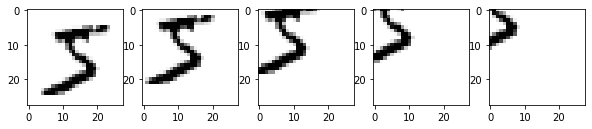

In [647]:
fig =  plt.figure(figsize= (10,10) )
for i in range(mov_len):
    fig.add_subplot(1,mov_len, i + 1)
    plt.imshow(data_mov[0,i,:].cpu().numpy(), cmap = 'Greys')

In [2732]:
main = V2.fullV1(a=  .8, b=.3, tau = 10)

In [2733]:
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1632 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.8,0.3, 10).',
 'Self-activation parameter is 0.5']

In [2734]:
x, funargs= main.init()

In [2735]:
Input = torch.rand(28,28)

In [2736]:
#Test run. SInce linear, should converge in 1 step for NR.
f = lambda x ,funargs: torch.tensor([[3,0],[0,1]]).float() @ x
df = lambda x, funargs: torch.tensor([[3,0],[0,1]]).float()
xinit = torch.tensor([0,0]).float()
NR.NR(f,df,xinit, [])

(tensor([0., 0.]), 1, 1)

In [2765]:
importlib.reload(FN)
importlib.reload(DS)

<module 'DAE_solver' from '/home/shazoop/form-and-motion/EE219A/DAE_solver.py'>

In [2766]:
fitz = FN.FN(n = 1, tau= 10)

In [2767]:
fitz.print_parms()

{'# neurons': 1, 'a': 0.7, 'b': 0.8, 'tau': 10}


In [2768]:
x = fitz.init()

In [2769]:
u = 3*torch.ones(1).float()

In [2770]:
DSsolve = DS.DAE_solver(fitz,x,u, funargs = [], h = .1, tstop = 10, method = 'BE')

In [2771]:
tpts, xpts = DSsolve.solve()

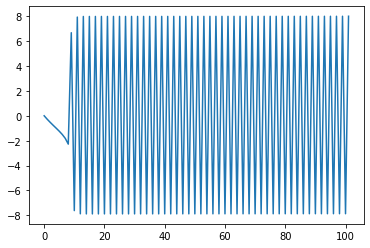

In [2772]:
plt.plot(xpts[:,0].cpu().numpy())

In [2753]:
xpts.shape

torch.Size([102, 2])

In [2986]:
importlib.reload(V1)
importlib.reload(DS)
importlib.reload(V2)

<module 'V1_DAE_v2' from '/home/shazoop/form-and-motion/EE219A/V1_DAE_v2.py'>

In [3012]:
main = V2.fullV1(tau = 50, lam = .5)

In [3013]:
main.print_allparms()

{'pixel dim': 28,
 'RF 1 dim': 12,
 'hidden layer depth': 16,
 'top layer depth': 16,
 'L1 stride': 4,
 'self-activate  parameter': 0.5,
 'a': 0.7,
 'b': 0.8,
 'tau': 50}

In [3014]:
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1632 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.7,0.8, 50).',
 'Self-activation parameter is 0.5']

In [3015]:
x, funargs = main.init()

In [3016]:
# N,n1,d1,d2,S1, lam, a, b, tau = main._parms.values()
# itau = 1/tau
# L1_dim = int((N+S1-n1)/S1) #one-sided: number of units
# L1sq = int(L1_dim**2)
# N1 = L1sq*d1
# N2 = d2
# ttlN = 3*N1 + 3*N2
# y,v,w,v_z,w_z,z = main.getVars(x)
# W,A = funargs

# Q = torch.zeros(N1,N1)
# Q1 = (torch.ones(d1,d1) - lam*torch.eye(d1))
# for i in range(L1sq):
#     Q[i*d1:(i+1)*d1, i*d1:(i+1)*d1] = Q1
# J[:N1,:N1] = torch.diag(V1.drelu(V1.logG(u) - Q @ y)) @ (-Q) - torch.eye(N1)  


In [3017]:
u = main.uMul(data_mov[1,0],funargs)

In [3018]:
DSsolve = DS.DAE_solver(main,x,u, funargs = funargs, h = .1, tstop = 7, method = 'BE', \
                        NRparms = {'maxiter': 200, 'reltol': 1e-3, 'abstol': 1e-3, 'restol': 1e-4, 'convcrit': 'dxORres' })

In [3019]:
_,xpts = DSsolve.solve()

In [3020]:
y,v,w,v_z,w_z,z = main.getVars(xpts[len(xpts)-1])

In [3021]:
ix = y.argmax().item()

In [3022]:
y.shape

torch.Size([400])

(array([358.,  13.,   3.,   6.,   3.,   4.,   6.,   3.,   1.,   3.]),
 array([0.        , 0.25029024, 0.5005805 , 0.75087076, 1.001161  ,
        1.2514513 , 1.5017415 , 1.7520318 , 2.002322  , 2.2526124 ,
        2.5029025 ], dtype=float32),
 <a list of 10 Patch objects>)

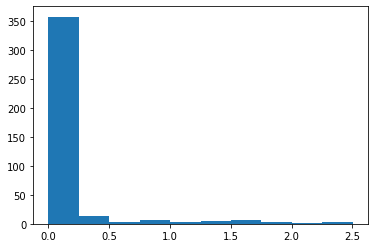

In [3023]:
plt.hist(y.cpu().numpy())

In [3024]:
v.argmax()

tensor(144)

(array([  9.,   0.,   0.,   3., 382.,   0.,   0.,   0.,   0.,   6.]),
 array([-7.9113517 , -6.3223715 , -4.7333913 , -3.1444108 , -1.5554305 ,
         0.03354979,  1.6225301 ,  3.2115104 ,  4.800491  ,  6.389471  ,
         7.9784513 ], dtype=float32),
 <a list of 10 Patch objects>)

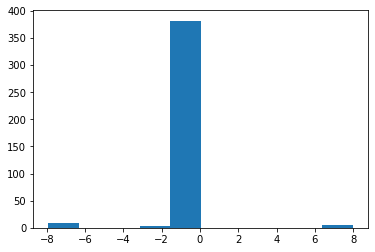

In [3025]:
plt.hist(v.cpu().numpy())

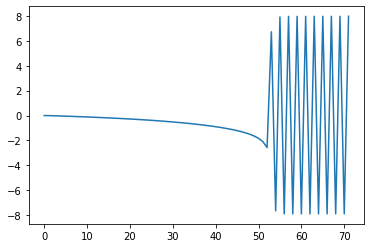

In [3026]:
plt.plot(xpts[:,ix+400].cpu().numpy())

In [3027]:
v_z.argmax()

tensor(1)

In [3028]:
xpts.shape

torch.Size([72, 1632])

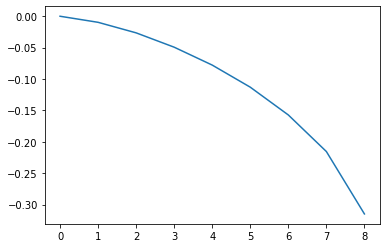

In [2932]:
plt.plot(xpts[:,15+1200].cpu().numpy())

In [2846]:
torch.max(1/102*(xpts[:,400:800].abs()).sum(dim=0))

tensor(4.4127)

In [3072]:
importlib.reload(DS)
importlib.reload(V2)

<module 'V1_DAE_v2' from '/home/shazoop/form-and-motion/EE219A/V1_DAE_v2.py'>

In [3082]:
main = V2.fullV1( tau = 12.6, lam = .5)
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1632 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.7,0.8, 12.6).',
 'Self-activation parameter is 0.5']

In [3088]:
N, L1,d1,d2 = main.print_parms()

trainSteps = 500
par1 = .008
par2 = .008
par3 = .2

In [3089]:
x, funargs = main.init()
W,A = funargs

In [ ]:
for train in range(trainSteps):
    input_mov = data_mov[int(np.random.randint(0,data_mov.size(0),1))] #select a random movie sequence
    x = main.xinit()
    for i in range(mov_len):
        uPix = main.pixel_mask(input_mov[i])
        u = main.uMul(input_mov[i],funargs)
        DSsolve = DS.DAE_solver(main,x,u, funargs = funargs, h = .1, tstop = 7, method = 'BE', \
                        NRparms = {'maxiter': 200, 'reltol': 1e-2, 'abstol': 1e-2, 'restol': 1e-3, 'convcrit': 'dxORres' })
        _,xpts = DSsolve.solve()
        T = len(xpts)
        v_trace = 1/T*(xpts[:,400:800]**2).sum(dim=0) #average power
        vz_trace = 1/T*(xpts[:,1200:1216]**2).sum(dim=0) #average power
        dW = torch.einsum('abc,abn -> abcn', v_trace.reshape(L1,L1,d1),uPix)
        W = W + par1*dW
        dA = torch.einsum('i,j -> ij', vz_trace,v_trace)
        A = A + par2*dA
        x = xpts[len(xpts)-1]
        funargs = (W,A)
        if i == 0:
            vz_avg = vz_trace
        else:
            vz_avg = (1-par3)*vz_avg + par3*vz_trace
    print(train)
        
        
        
        
        



NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 2.3000000000000007, step 23
0

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 6.999999999999991, step 70
1

NR failed to solve nonlinear equations - reached maxiter=200
NR failed to converge at time 2.1000000000000005, step 21


In [3052]:
W_F,A_F = funargs

In [3091]:
W,A=funargs

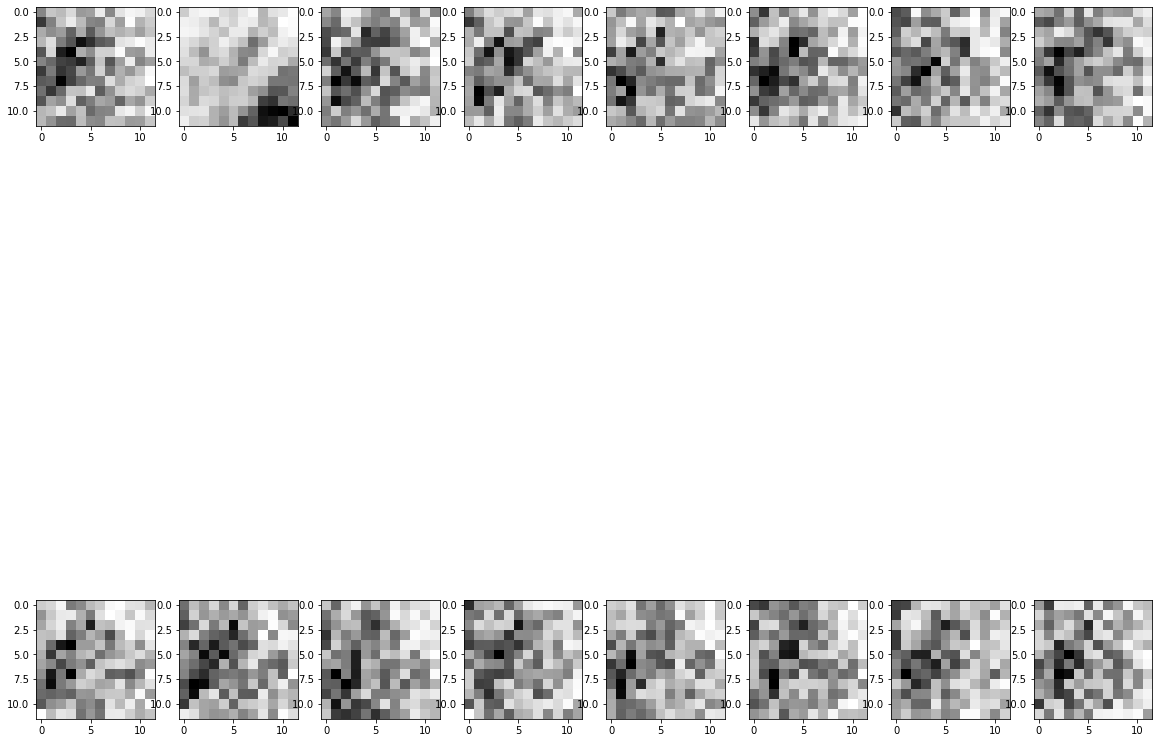

In [3092]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(W[0,0,i,:].reshape(12,12).cpu().numpy(),cmap='Greys')

In [3049]:
y,v,w,v_z,w_z,z = main.getVars(xpts[len(xpts)-1])

In [3050]:
ix = y.argmax().item()

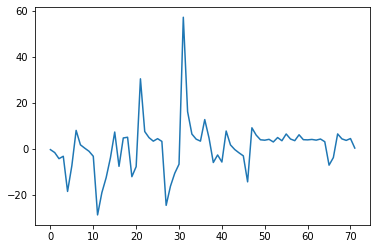

In [3051]:
plt.plot(xpts[:,ix+400].cpu().numpy())

In [2872]:
        v_trace = 1/T*(xpts[:,400,800]**2).sum(dim=0) #average power


IndexError: too many indices for tensor of dimension 2

In [ ]:
torch.cat((torch.cat((a,b), dim = 0),c), dim = 0)

In [ ]:
C  = torch.stack((a,b))

In [ ]:
a